In [2]:
import numpy as np
import tensorflow as tf

from glob import glob as glob
from itertools import product

from pureEM import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# PM task ideas

- PMtask
    - first trial: net given PM cue, responds with PM action
    - subsequent trials: nback task

- WM architecture
    - pure LSTM
- WM+EM architecture
    - first trial, store M = {PMcue:cell_state} 
    - on each trial 
        - if sim(S_t,M)>threshold: reinstate 
        - else perform nback
        
- goals/questions
    - after hand crafted reinstatement, try graded reinstatement gate
        - gate = sim(S_t,M) 
        - gate = f(sim(s_t,M))


### todo 
- cluster param sweep


In [363]:
net = PMNet(30,num_og_tokens=3,seed=2)
task = NBackPMTask(nback=2,num_og_tokens=3,ntrials_pm=4)
trainer = Trainer(net,task)

randomizing pm embed
lstm2, in+out layers with do_


In [364]:
train_acc,train_cum_rands = trainer.train_closed_loop(100000,20,thresh=.99)

0.0 0.3 0
0.05 0.8 31
0.1 0.85 70
0.15 0.75 115
0.2 0.9 185
0.25 0.8 310
0.3 0.7 437
0.35 0.75 571
0.4 0.6 705
0.45 0.65 831
0.5 0.85 973
0.55 0.95 1123
0.6 0.8 1338
0.65 0.7 1686
0.7 0.9 2114
0.75 0.9 2736
0.8 0.55 3411
0.85 1.0 4216
0.9 0.9 5155
0.95 1.0 6183


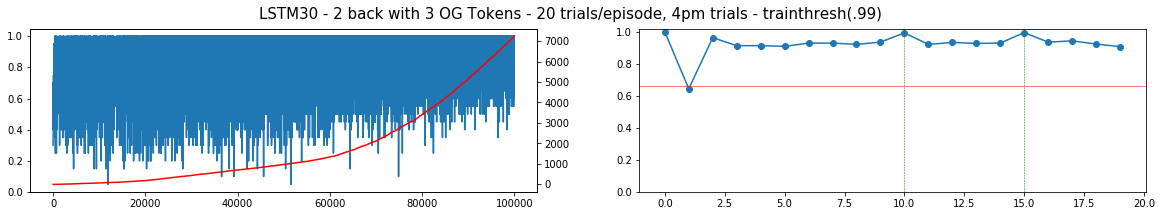

In [378]:
fig,axarr = plt.subplots(1,2,figsize=(20,3));axarr=axarr.reshape(-1)
# train
ax=axarr[0]
ax.plot(train_acc)
ax2 = ax.twinx()
ax2.plot(train_cum_rands,c='r')

# eval
eval_acc = trainer.eval_loop(500,ntrials=20).mean(0)
ax=axarr[1]
ax.plot(eval_acc)
ax.scatter(range(20),eval_acc)
for t in [10,15]:
  ax.axvline(t,c='g',lw=.5,ls='--')
ax.axhline(.66,c='r',lw=.5)
ax.set_ylim(0,1.02)

plt.suptitle('LSTM30 - 2 back with 3 OG Tokens - 20 trials/episode, 4pm trials - trainthresh(.99)\n\n',fontsize=15)
plt.savefig('figures/dual_PM_task')

In [340]:
task = NBackPMTask(nback=2,num_og_tokens=3,ntrials_pm=0)
X,Y = task.gen_seq()

for x,y in zip(X.squeeze(),Y.squeeze()):
  print(x,y)

3 2
0 1
1 0
0 1
1 1
1 0
2 0
0 0
2 1
0 1
0 0
0 1
2 0
1 0
2 1
2 0
0 0
1 0
1 0
1 1
1 1
0 0
1 1
0 1
0 0
1 0
2 0
0 0
2 1
0 1


## older figs

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(train_acc)
for t in range(0,10000,100):
  plt.axvline(t,c='r',lw=.2)
plt.ylabel('accuracy')
plt.xlabel('training episode/epoch')
plt.title('LSTM20 training accuracy')
# plt.savefig('figures/nback+pm/training_acc-2back_2tokens')

In [ ]:
plt.figure(figsize=(13,4))
eps = 100
eval_acc = trainer.eval_loop(eps,25)
M = eval_acc.mean(0)
S = eval_acc.std(0)/np.sqrt(eps)
plt.plot(M,c='blue')
plt.fill_between(range(len(M)),M-S,M+S,alpha=.3)
plt.scatter(range(len(M)),M,c='blue')
for t in [10,15]:
  plt.axvline(t,c='g',lw=1)
plt.ylim(0,1.05)
plt.ylabel('mean acc')
plt.xlabel('trial')
plt.title('LSTM20 eval accuracy')
# plt.savefig('figures/nback+pm/eval_acc-2back_2tokens')

# from cluster

- stsize_arr=(10 20 30 40 50)
- ogtoken_arr=(2 3 4 5 10 15 20)
- pmtrial_arr=(1 2 3 4 5 10)
- nback 2,3,4

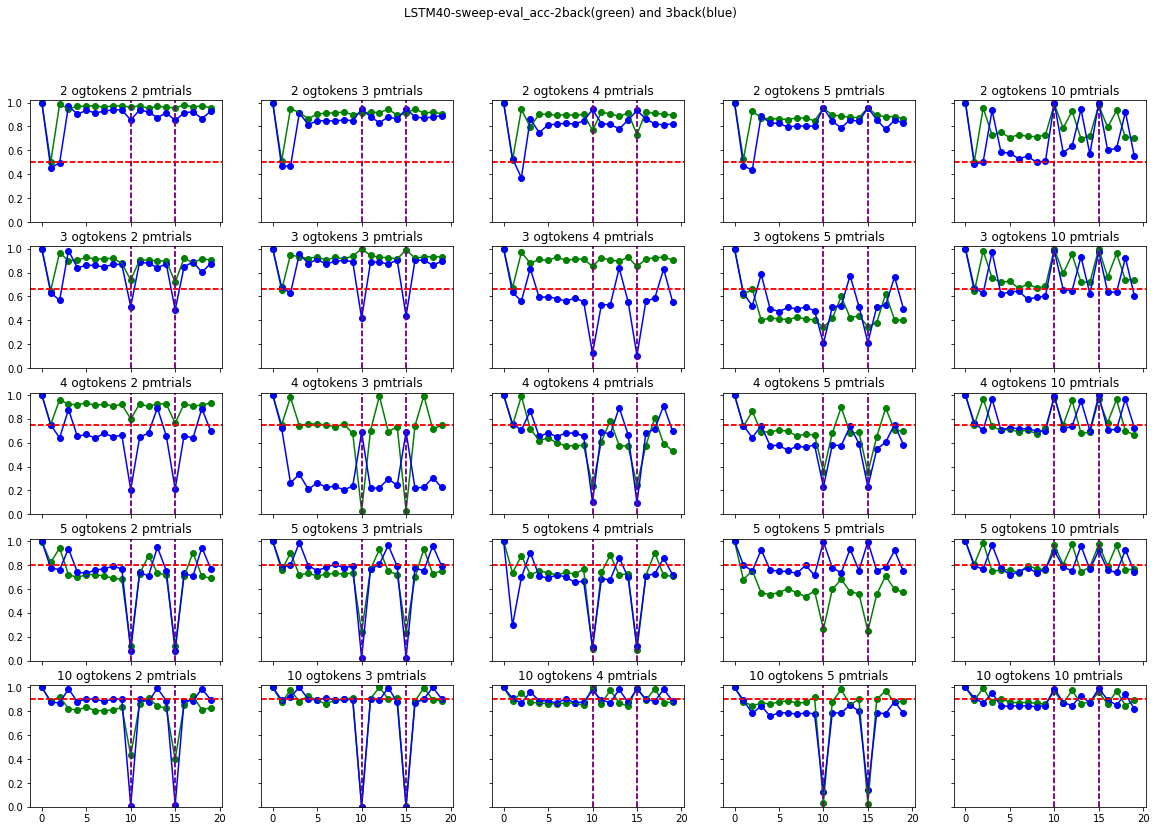

In [16]:
from itertools import product

stsize = 40
ogtokenL = [2,3,4,5,10]
pmtrialL = [2,3,4,5,10]
nbackL = [2,3]
nbackL_c = ['g','b']

nsubs = 1
trial_len = 20

fig,axarr = plt.subplots(5,5,figsize=(20,13),sharex=True,sharey=True);axarr=axarr.reshape(-1)

for idx,(ogtokens,pmtrials) in enumerate(product(ogtokenL,pmtrialL)):
  ax = axarr[idx]
  ax.set_title("%i ogtokens %i pmtrials"%(ogtokens,pmtrials))
  for nback_idx,nback in enumerate(nbackL):
    group_acc = -np.ones([nsubs,trial_len])
    for seed in range(1,nsubs+1):
      fpathL = glob("model_data/nback+pm/"+\
                    "lstm_%i-nback_%i-ogtokens_%i-pmtrials_%i-seed_?-eval_acc.npy"%(
                      stsize,nback,ogtokens,pmtrials))
      if not len(fpathL): 
        print('none for',stsize,nback,ogtokens,pmtrials)
        continue
      fpath = fpathL[0]
#       print(fpath)
      subj_acc = np.load(fpath).mean(0)
      group_acc[seed-1] = subj_acc

    M = group_acc.mean(0)
    S = group_acc.std(0)/np.sqrt(len(group_acc))

    ax.plot(M,c=nbackL_c[nback_idx])
    ax.scatter(range(len(M)),M,c=nbackL_c[nback_idx])
    ax.fill_between(range(len(M)),M-S,M+S,alpha=.5)

    ax.set_ylim(0,1.02)
    ax.axvline(10,c='purple',ls='--')
    ax.axvline(15,c='purple',ls='--')
    ax.axhline(1-(1/ogtokens),c='r',ls='--')


title = 'LSTM%i-sweep-eval_acc'%(stsize)
plt.suptitle(title+'-2back(green) and 3back(blue)')
plt.savefig('figures/'+title)


In [118]:
stsize = 10
nback = 2
ogtokens = 5
pmtrials = 3
stsizeL = [10,20]
nback = [2,3]




In [125]:




print(fpathL)

['model_data/nback+pm/lstm_50-nback_2-ogtokens_3-pmtrials_4-seed_3-eval_acc.npy', 'model_data/nback+pm/lstm_50-nback_2-ogtokens_3-pmtrials_4-seed_2-eval_acc.npy', 'model_data/nback+pm/lstm_50-nback_2-ogtokens_3-pmtrials_4-seed_1-eval_acc.npy']


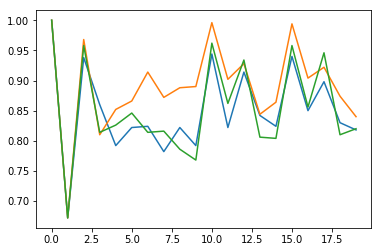

In [127]:
plt.plot(group_data.mean(1).T)

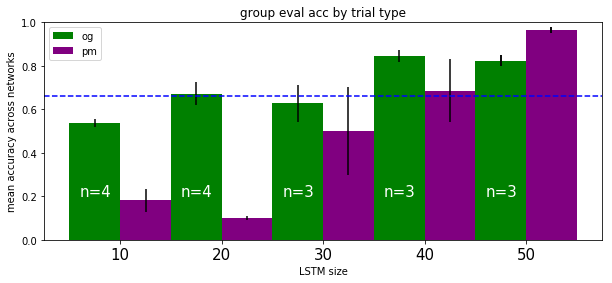

In [188]:
plt.figure(figsize=(10,4))
ax = plt.gca()
og_trials = [8,9]
pm_trials = [10,15]

stsizeL = [10,20,30,40,50]
nback = 2
ogtokens = 3
pmtrials = 4

for group_id,stsize in enumerate(stsizeL):
  fpathL = glob("model_data/nback+pm/"+\
            "lstm_%i-nback_%i-ogtokens_%i-pmtrials_%i-seed_?-eval_acc.npy"%(
              stsize,nback,ogtokens,pmtrials))

  # load group data
  eval_itr = 500
  ntrials = 20
  nnets = len(fpathL)
  group_data = -np.ones([nnets,eval_itr,ntrials])
  for net_id,fpath in enumerate(fpathL):
    sub_data = np.load(fpath)
    group_data[net_id] = sub_data

  # compute means
  net_acc = group_data.mean(1)
  net_og_acc = net_acc[:,og_trials].mean(1)
  net_pm_acc = net_acc[:,pm_trials].mean(1)

  M_og = net_og_acc.mean()
  M_pm = net_pm_acc.mean()
  S_og = net_og_acc.std()/np.sqrt(nnets)
  S_pm = net_pm_acc.std()/np.sqrt(nnets)

  # plot
  ax.bar(group_id,M_og,yerr=S_og,width=.5,color='g')
  ax.bar(group_id+0.5,M_pm,yerr=S_pm,width=.5,color='purple')
  ax.text(group_id-.15,0.2,"n=%i"%nnets,color='white',size=15)
  
ax.bar(group_id,M_og,yerr=S_og,width=.5,color='g',label='og')
ax.bar(group_id+0.5,M_pm,yerr=S_pm,width=.5,color='purple',label='pm')

ax.set_label('abc')
plt.legend()
ax.set_ylim(0,1)
ax.axhline(0.66,c='blue',ls='--')
ax.set_xticks(np.arange(len(stsizeL))+.25)
ax.set_xticklabels(stsizeL,fontsize=15)
ax.set_ylabel('mean accuracy across networks')
ax.set_xlabel('LSTM size')

plt.title('group eval acc by trial type')
plt.savefig('figures/nback+pm/eval_acc_by_trial_type')
